In [74]:
# imports
import requests
import pandas as pd
import numpy as np
import json
import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
# Importing CityBike dataframe
df_stations = pd.read_csv('df_stations.csv')[['id','name','total_bikes','latitude','longitude']]
df_stations.head()

,id,name,total_bikes,latitude,longitude
0,d334f65221f6a681f8b03433f36e2075,T19 Kiwanis Park,9,33.366488,-111.935612
1,cac663c57dee1dafd5f152bb906e97d5,P211 10th St / Pierce,6,33.455654,-112.060592
2,8d29ea89964d1eb73171310f718fe7e5,P196 2nd St. and Roosevelt,9,33.458995,-112.071128
3,6628d10945695a8a19a0ede32f949bc4,T17 Tempe Beach Park,23,33.429720,-111.940602
4,b953cdb6c1721e12c870e32cb780998c,ASU Goldwater Ctr. for Science - Tyler Mall (V...,6,33.420541,-111.930670


# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

Put your parsed results into a DataFrame

In [8]:
# Using dotenv to retrieve Foursquare API key
load_dotenv()
api_key_fs_string = 'FOURSQUARE_API_KEY' # replace with your Foursquare API key environment variable name
api_key_fs = os.getenv(api_key_fs_string)

In [9]:
# Defining function to find all POI's in Foursquare of a specific category within a set distance from any bike stations
def find_POIs_foursquare(station_ids,latitudes,longitudes,radius,limit,category_ids):
    
    fields = 'fsq_id,name,rating,popularity,price'
    list_POI = []
    
    # Find all POI's within 1000m of each bike station.  This will return one column with station_id and one column containing lists of POI's.
    for stat_ids,lat,long in zip(station_ids,latitudes,longitudes):
        url = f'https://api.foursquare.com/v3/places/search?ll={lat},{long}&radius={radius}&categories={category_ids}&limit={limit}&fields={fields}'
        headers = {"accept": "application/json","Authorization": api_key_fs}
        response = requests.get(url, headers=headers).json()['results']
        list_POI.append([stat_ids,response])
   
    # convert to dataframe
    df = pd.DataFrame(list_POI,columns=['station_id','results'])

    # create 1 row for each match of bike station and POI.  There are duplicates of both bike stations and POI's, but each matchup is unique.
    df = df.explode('results').reset_index(drop=True) 
    df = pd.concat([df,pd.json_normalize(df['results'])],axis=1).drop('results',axis=1)
    return df

In [10]:
# From the CityBike documentation, the category IDs for Bars and Restaurants are 13003 and 13065 respectfully

# Creating dataframe for bars/restaurants
df_restaurants_bars_fs = find_POIs_foursquare(station_ids=df_stations['id'],
                                          latitudes=df_stations['latitude'],
                                          longitudes=df_stations['longitude'],
                                          radius=500,
                                          limit=50,
                                          category_ids='13003,13065')


df_restaurants_bars_fs.head()

,station_id,fsq_id,name,popularity,price,rating
0,d334f65221f6a681f8b03433f36e2075,NaN,NaN,NaN,NaN,NaN
1,cac663c57dee1dafd5f152bb906e97d5,5affb890efa82a002ca277b6,Welcome Diner,0.972516,1.0,8.6
2,cac663c57dee1dafd5f152bb906e97d5,59403814dec1d64454097bd6,Gallo Blanco,0.976443,1.0,8.5
3,cac663c57dee1dafd5f152bb906e97d5,57d77982498e47efcfc81c65,Cheba Hut,0.988632,1.0,8.9
4,cac663c57dee1dafd5f152bb906e97d5,5fa1d6942789095b87e8f481,Tacos Calafia - Downtown,0.987102,1.0,NaN


### EDA

In [73]:
df_restaurants_bars_fs

,station_id,fsq_id,name,popularity,price,rating
0,d334f65221f6a681f8b03433f36e2075,NaN,NaN,NaN,NaN,NaN
1,cac663c57dee1dafd5f152bb906e97d5,5affb890efa82a002ca277b6,Welcome Diner,0.972516,1.0,8.6
2,cac663c57dee1dafd5f152bb906e97d5,59403814dec1d64454097bd6,Gallo Blanco,0.976443,1.0,8.5
3,cac663c57dee1dafd5f152bb906e97d5,57d77982498e47efcfc81c65,Cheba Hut,0.988632,1.0,8.9
4,cac663c57dee1dafd5f152bb906e97d5,5fa1d6942789095b87e8f481,Tacos Calafia - Downtown,0.987102,1.0,NaN
...,...,...,...,...,...,...
1889,0e1960d94d8ab3ead0f26ddbd1cbf938,62dad6c2967350706326a8d6,Coffee Lounge,0.962606,3.0,NaN
1890,0e1960d94d8ab3ead0f26ddbd1cbf938,4ac11e0ef964a520e89520e3,Subway,0.863012,1.0,5.2
1891,0e1960d94d8ab3ead0f26ddbd1cbf938,d2baa5fee8414d479184fad1,Adams Table,NaN,NaN,NaN
1892,0e1960d94d8ab3ead0f26ddbd1cbf938,e2ee4b615a58967fa94fba0d,El Zaguan Bistro,NaN,NaN,NaN


Text(0.5, 0.98, 'Foursquare Strip Plots')

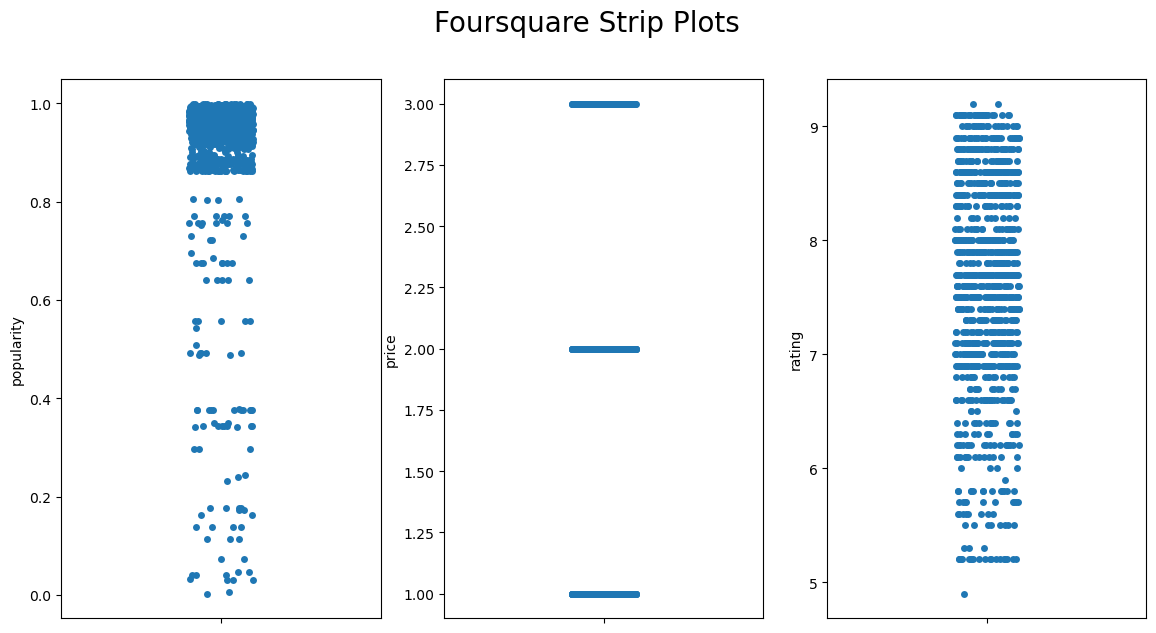

In [106]:
# Plotting Foursquare dataframe columns on strip plots to identify any outliers.  No significant outliers that need to be removed.

fig, axes = plt.subplots(1, 3, figsize=(14, 7))
sns.stripplot(ax=axes[0], data=df_restaurants_bars_fs['popularity'])
sns.stripplot(ax=axes[1], data=df_restaurants_bars_fs['price'])
sns.stripplot(ax=axes[2], data=df_restaurants_bars_fs['rating'])
fig.suptitle('Foursquare Strip Plots', fontsize=20)

In [107]:
# Writing FourSquare dataframe to csv
df_restaurants_bars_fs.to_csv(path_or_buf='df_restaurants_bars_fs.csv',index=False)

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

Put your parsed results into a DataFrame

In [12]:
# Using dotenv to retrieve Yelp API key
load_dotenv()
api_key_y_string = 'YELP_API_KEY2' # replace with your Yelp API key variable name
api_key_y = os.getenv(api_key_y_string)

In [13]:
# Definging the function to find all POI's in Yelp of a specific category within a set distance from any bike stations
def find_POIs_yelp(station_ids,latitudes,longitudes,radius,limit,categories):
    
    #fields = 'fsq_id,name,rating,popularity,price'
    list_POI = []
    
    # Find all POI's within 1000m of each bike station.  This will return one column with station_id and one column containing lists of POI's.
    for stat_ids,lat,long in zip(station_ids,latitudes,longitudes):
        url = f'https://api.yelp.com/v3/businesses/search?latitude={lat}&longitude={long}&radius={radius}&limit={limit}&categories={categories}'
        headers = {"accept": "application/json","Authorization": 'bearer ' + api_key_y}
        response = requests.get(url, headers=headers).json()['businesses']
        list_POI.append([stat_ids,response])
    
    # convert to dataframe
    df = pd.DataFrame(list_POI,columns=['station_id','businesses'])

    # create 1 row for each match of bike station to POI.  There are duplicates of both bike stations and POI's, but each matchup is unique.
    df = df.explode('businesses').reset_index(drop=True) 
    df = pd.concat([df,pd.json_normalize(df['businesses'])],axis=1).drop('businesses',axis=1)
    return df

In [53]:
# Using function to find Yelp POI's 
df_bars_yelp = find_POIs_yelp(station_ids=df_stations['id'],
                              latitudes=df_stations['latitude'],
                              longitudes=df_stations['longitude'],
                              radius=1000,
                              limit=50,
                              categories='bars')

# Viewing Yelp dataframe
df_bars_yelp.head()

,station_id,id,alias,name,image_url,is_closed,url,review_count,categories,rating,...,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address
0,d334f65221f6a681f8b03433f36e2075,5Ks4F3IOvSLi0KePlhr-sw,bogeys-grill-tempe,Bogeys Grill,https://s3-media2.fl.yelpcdn.com/bphoto/LTJkXM...,False,https://www.yelp.com/biz/bogeys-grill-tempe?ad...,147.0,"[{'alias': 'sportsbars', 'title': 'Sports Bars...",4.0,...,33.363330,-111.928080,6463 S Rural Rd,,,Tempe,85283,US,AZ,"[6463 S Rural Rd, Tempe, AZ 85283]"
1,cac663c57dee1dafd5f152bb906e97d5,5V8O-vas5A4XGWqxsJ7GBg,the-farish-house-phoenix,The Farish House,https://s3-media1.fl.yelpcdn.com/bphoto/MIUadT...,False,https://www.yelp.com/biz/the-farish-house-phoe...,286.0,"[{'alias': 'wine_bars', 'title': 'Wine Bars'},...",4.5,...,33.457201,-112.070250,816 N 3rd St,,None,Phoenix,85004,US,AZ,"[816 N 3rd St, Phoenix, AZ 85004]"
2,cac663c57dee1dafd5f152bb906e97d5,snnblypVofvG3OKMUKWO6A,il-bosco-pizza-phoenix,IL Bosco Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/Kho2d0...,False,https://www.yelp.com/biz/il-bosco-pizza-phoeni...,160.0,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,...,33.458339,-112.067768,918 N 5th St,,None,Phoenix,85004,US,AZ,"[918 N 5th St, Phoenix, AZ 85004]"
3,cac663c57dee1dafd5f152bb906e97d5,QEBJq71ph_qtmQyCPNrwPw,palma-phoenix-4,Palma,https://s3-media4.fl.yelpcdn.com/bphoto/bY7Okp...,False,https://www.yelp.com/biz/palma-phoenix-4?adjus...,323.0,"[{'alias': 'sushi', 'title': 'Sushi Bars'}, {'...",4.0,...,33.457980,-112.070840,903 N 2nd St,None,,Phoenix,85004,US,AZ,"[903 N 2nd St, Phoenix, AZ 85004]"
4,cac663c57dee1dafd5f152bb906e97d5,aEtbXqbkf2BnwEVWQ2yjUw,taco-chelo-phoenix,Taco Chelo,https://s3-media2.fl.yelpcdn.com/bphoto/egDzn5...,False,https://www.yelp.com/biz/taco-chelo-phoenix?ad...,712.0,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,...,33.458515,-112.067262,501 E Roosevelt St,,None,Phoenix,85004,US,AZ,"[501 E Roosevelt St, Phoenix, AZ 85004]"


In [57]:
# Only including needed columns
df_bars_yelp = df_bars_yelp[['station_id', 'id', 'name',
       'review_count', 'rating', 'price']]

df_bars_yelp.head()

,station_id,id,name,review_count,rating,price
0,d334f65221f6a681f8b03433f36e2075,5Ks4F3IOvSLi0KePlhr-sw,Bogeys Grill,147.0,4.0,$
1,cac663c57dee1dafd5f152bb906e97d5,5V8O-vas5A4XGWqxsJ7GBg,The Farish House,286.0,4.5,$$
2,cac663c57dee1dafd5f152bb906e97d5,snnblypVofvG3OKMUKWO6A,IL Bosco Pizza,160.0,4.5,$$
3,cac663c57dee1dafd5f152bb906e97d5,QEBJq71ph_qtmQyCPNrwPw,Palma,323.0,4.0,$$
4,cac663c57dee1dafd5f152bb906e97d5,aEtbXqbkf2BnwEVWQ2yjUw,Taco Chelo,712.0,4.0,$$


In [58]:
# Creating new ordinal 'price' column based on number of dollar signs ($) in 'price' column
df_bars_yelp['price2'] = df_bars_yelp['price'].str.len()
df_bars_yelp.head()

,station_id,id,name,review_count,rating,price,price2
0,d334f65221f6a681f8b03433f36e2075,5Ks4F3IOvSLi0KePlhr-sw,Bogeys Grill,147.0,4.0,$,1.0
1,cac663c57dee1dafd5f152bb906e97d5,5V8O-vas5A4XGWqxsJ7GBg,The Farish House,286.0,4.5,$$,2.0
2,cac663c57dee1dafd5f152bb906e97d5,snnblypVofvG3OKMUKWO6A,IL Bosco Pizza,160.0,4.5,$$,2.0
3,cac663c57dee1dafd5f152bb906e97d5,QEBJq71ph_qtmQyCPNrwPw,Palma,323.0,4.0,$$,2.0
4,cac663c57dee1dafd5f152bb906e97d5,aEtbXqbkf2BnwEVWQ2yjUw,Taco Chelo,712.0,4.0,$$,2.0


### EDA

Text(0.5, 0.98, 'Yelp Strip Plots')

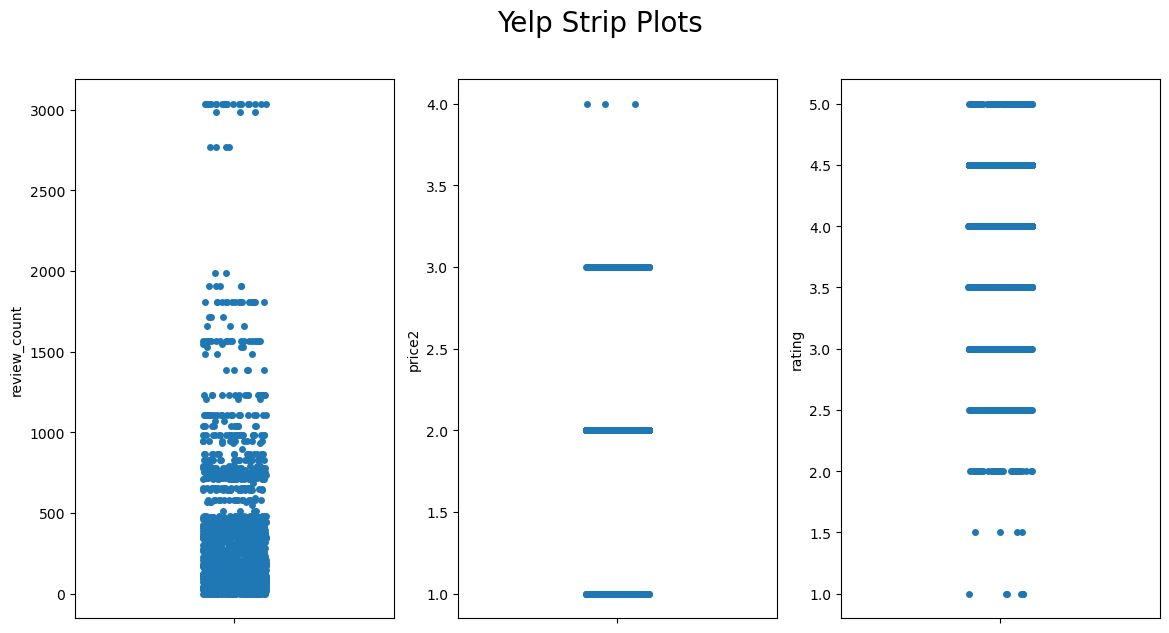

In [104]:
# Plotting Yelp dataframe columns on strip plots to identify any outliers.  No significant outliers that need to be removed.

fig, axes = plt.subplots(1, 3, figsize=(14, 7))
sns.stripplot(ax=axes[0], data=df_bars_yelp['review_count'])
sns.stripplot(ax=axes[1], data=df_bars_yelp['price2'])
sns.stripplot(ax=axes[2], data=df_bars_yelp['rating'])
fig.suptitle('Yelp Strip Plots', fontsize=20)

In [59]:
# Writing Yelp dataframe to csv
df_bars_yelp.to_csv(path_or_buf='df_bars_yelp.csv',index=False)

# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

In [64]:
# Percentage of Foursquare columns that are not null
print(df_restaurants_bars_fs.count()/df_restaurants_bars_fs.shape[0])
print()
print(str(df_restaurants_bars_fs.shape[0]) + ' rows')
print('Mean not null percentage: '+ str((df_restaurants_bars_fs.count()/df_restaurants_bars_fs.shape[0]).mean()))

station_id    1.000000
fsq_id        0.996832
name          0.996832
popularity    0.859029
price         0.780359
rating        0.566526
dtype: float64

1894 rows
Mean not null percentage: 0.8665962689193946


In [62]:
# Percentage of Yelp columns that are not null
print(df_bars_yelp.count()/df_bars_yelp.shape[0])
print()
print(str(df_bars_yelp.shape[0]) + ' rows')
print('Mean not null percentage: '+ str((df_bars_yelp.count()/df_bars_yelp.shape[0]).mean()))

station_id      1.000000
id              0.999635
name            0.999635
review_count    0.999635
rating          0.999635
price           0.779358
price2          0.779358
dtype: float64

2742 rows
Mean not null percentage: 0.9367510680420964


In [55]:
# Yelp data is more complete

0.966652078774617

Get the top 10 restaurants according to their rating

In [65]:
# Foursquare top 10 according to rating
df_restaurants_bars_fs.sort_values('rating',ascending=False).drop_duplicates('name').head(10)

,station_id,fsq_id,name,popularity,price,rating
824,ebb4ed2cfc9d563f8f15f9861a3ebccf,4a5fcb9cf964a5203cc01fe3,Postino Central,0.981644,2.0,9.2
616,ce9511579a675c959184e01c7bbee502,4a3fdf4cf964a52004a41fe3,Cibo,0.977967,2.0,9.1
1685,cb4373b3cc89e041a72730400204f509,55600416498e5eb4dbecf791,Valley Bar,0.977441,2.0,9.1
479,03712bfd188583696010813718ea01e1,5085c381e4b038e4e19d739e,Federal Pizza,0.982590,2.0,9.1
435,c1b890c63cf0a734dca62f21afc42b5d,502ac807e4b02d4e93003f14,Angels Trumpet Ale House,0.976548,2.0,9.1
430,c1b890c63cf0a734dca62f21afc42b5d,4e3a4cdf1850f0453401b5fd,Crescent Ballroom,0.992237,1.0,9.1
182,ccfd57f453bbdacff8a335974083d103,52ce0ca6498e4e9046c318f9,El Chullo,0.964563,2.0,9.1
244,7139afb8e84dae818c1edeff867e735d,472edc25f964a5200a4c1fe3,Matt's Big Breakfast,0.977500,2.0,9.0
1290,752f87eeda59a838aa157b0345d09cbb,58c0eed0ef787f4192ad1f4a,Novel Ice Cream,0.966796,1.0,9.0
1829,12e404d96fb464df02d1451942333ceb,51a9565a498e75de58509959,Pomo Pizzeria Phoenix,0.979122,2.0,9.0


In [71]:
# Yelp top 10 according to rating. Sorted by rating and review_count.
df_bars_yelp.sort_values(['rating','review_count'],ascending=False).drop_duplicates('name').head(10)

,station_id,id,name,review_count,rating,price,price2
749,03712bfd188583696010813718ea01e1,S9r0hs4TwmswVk0yxtPUwQ,The Captain's Cabin,53.0,5.0,NaN,NaN
79,8d29ea89964d1eb73171310f718fe7e5,WZS3WagNuA-APAX1Eqp26g,Garden Bar Phoenix,50.0,5.0,NaN,NaN
2166,760018a4709e9cbea1a7d1f35fd2e323,3SrrfQOOx-NsdthzEztVAg,Rift Wine Tap,35.0,5.0,NaN,NaN
729,213a97958a0e81bf960e47d235cb85d4,BfcjudgaW1dGgCx6eQz1zA,The Wayward Taphouse,28.0,5.0,NaN,NaN
23,cac663c57dee1dafd5f152bb906e97d5,9CZ1u9xailwxWwgKbubgeA,Concierge Bistro Bar,15.0,5.0,NaN,NaN
123,6628d10945695a8a19a0ede32f949bc4,RD4DT9opiW_00Dq7FYaNng,University Sports Grill,5.0,5.0,NaN,NaN
631,c0932901743359c499780029d8549433,H2HeOmDaztHe3TjLTj4YFw,Food On Wood,5.0,5.0,NaN,NaN
36,cac663c57dee1dafd5f152bb906e97d5,097Q9N5XyIDFDK0kQcyRjQ,Moiselle,3.0,5.0,NaN,NaN
117,6628d10945695a8a19a0ede32f949bc4,95MO0h7grooyjn0lsJaNnw,AC Lounge,3.0,5.0,NaN,NaN
584,73a535604a1fd81e210b797aa4b56c99,A4daIOZASO-wxDJzWhHD0g,Van Daddies,2.0,5.0,NaN,NaN
